# Проект для маркетплейса c BERT

Исследование для интернет-магазина. Магазин запустил новый сервис: теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других. Нужно построить модель, которая будет классифицировать комментарии на позитивные и негативные. В распоряжении исследователя набор данных с разметкой о токсичности правок. Значение метрики качества F1 должно быть не меньше 0.75.

In [1]:
# загружаю все нужные для проекта библиотеки

import pandas as pd
import os

import nltk
import numpy as np
import re
import torch
import transformers
import matplotlib.pyplot as plt


from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForMaskedLM

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_data(file_name): # загрузка данных
    data = pd.read_csv(file_name, index_col=0)
    print(data.head())
    data.info()
    return data

def preprocess_text(text): # предобработка текста перед токенизацией
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text)
    processed_text = re.sub(r'<.*?>', ' ', processed_text)
    processed_text = processed_text.lower()
    return processed_text

def tokenize(text): # токенизация текста
    tokenized = text.apply(lambda x: tokenizer.encode(x, max_length=MAX_LENGTH, padding='max_length', truncation=True, add_special_tokens=True))
    padded = np.array([i + [0]*(MAX_LENGTH - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    return tokenized, attention_mask

def embedder(tokenized, attention_mask): # эмбеддинги
    embeddings = []
    for i in notebook.tqdm(range(tokenized.shape[0] // BATCH_SIZE)):
        slice_top = BATCH_SIZE*(i+1)
        if slice_top == 159200:
            slice_top = tokenized.shape[0]
        batch = torch.LongTensor(tokenized[BATCH_SIZE*i:slice_top].tolist()).to(mps_device)
        attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE*i:slice_top]).to(mps_device)
        batch = batch.to(mps_device)
        attention_mask_batch = attention_mask_batch.to(mps_device)
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        batch_embeddings = batch_embeddings[0][:,0,:].to('cpu')
        embeddings.append(batch_embeddings.numpy())
    return embeddings

def conctateneter(embeddings, dataset): # конкатенация эмбеддингов и оригинального датасета
    features = np.concatenate(embeddings)
    features_df = pd.DataFrame(features, columns=['feature' + str(i) for i in range(features.shape[1])])
    data = pd.concat([dataset, features_df], axis=1)
    return data

## Загрузка и изучение данных

In [3]:
pth1 = '/Users/ira-bobrineva/Downloads/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    text_data = load_data(pth1)
elif os.path.exists(pth2):
    text_data = load_data(pth2)
else:
    print('Что-то не так')

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


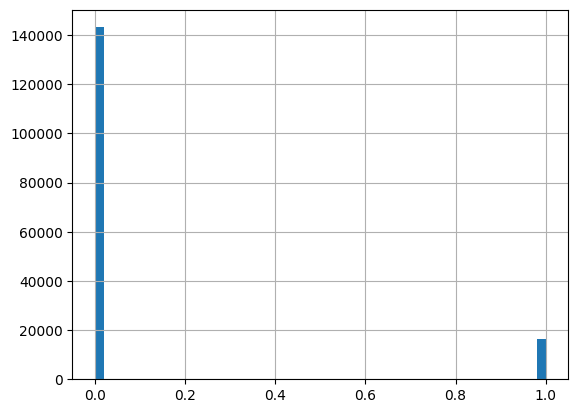

In [4]:
text_data['toxic'].hist(bins=50)
plt.show()

В таргете есть дисбаланс классов, нужно будет их сбалансировать при обучении модели.

## Обработка текста

In [5]:
RANDOM_STATE = 42

# разделение на выборки перед эмбеддингами
text_data = text_data.sample(500).reset_index(drop=True)

# разделение на выборки перед эмбеддингами, чтобы не было утечки таргета

train, test = train_test_split(text_data, test_size=0.5, random_state=RANDOM_STATE, stratify=text_data['toxic'])

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# предобрабатываю колонку перед эмбеддингами

features_train_cut = train['text'].apply(preprocess_text)


In [6]:
MAX_LENGTH = 512
BATCH_SIZE = 50

# тут делаю так, чтобы процессы GPU использовали, а не CPU. У меня мак на M1
mps_device = torch.device("cuda")

model = transformers.AutoModel.from_pretrained('unitary/toxic-bert').to(mps_device)
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized, attention_mask= tokenize(features_train_cut)

C:\Users\danas\DataspellProjects\untitled\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\danas\DataspellProjects\untitled\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
embeddings = embedder(tokenized, attention_mask)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
data = conctateneter(embeddings, train)
data.shape

(250, 770)

In [9]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X = data.drop(['toxic', 'text'], axis=1)
y = data['toxic']

pipe_final = Pipeline(
    [
        ('models', LogisticRegression())
    ]
)

param_distributions = [
    # словарь для модели LogisticRegression()
    {   
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'models__class_weight': ['balanced']
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11)
    }
]

# применила это, чтобы починить то, что токенизатор вызывается перед тем, как процесс разветвляется для параллельных вычислений, использую не все ядра
n_jobs = os.cpu_count() - 1

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=n_jobs,
    error_score='raise'
)
# применила это, чтобы починить то, что токенизатор вызывается перед тем, как процесс разветвляется для параллельных вычислений
if __name__ == '__main__':
    randomized_search.fit(X, y)

best_model = randomized_search.best_estimator_

best_model

Pipeline(steps=[('models',
                 LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [10]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.max_colwidth', 10000)

   rank_test_score                                       param_models  \
2                1  LogisticRegression(penalty='l1', random_state=...   
5                1  LogisticRegression(penalty='l1', random_state=...   
6                1  LogisticRegression(penalty='l1', random_state=...   
0                4            DecisionTreeClassifier(random_state=42)   
1                4            DecisionTreeClassifier(random_state=42)   
3                4            DecisionTreeClassifier(random_state=42)   
4                4            DecisionTreeClassifier(random_state=42)   
7                4            DecisionTreeClassifier(random_state=42)   
8                4            DecisionTreeClassifier(random_state=42)   
9                4            DecisionTreeClassifier(random_state=42)   

   mean_test_score                                             params  
2         0.933822  {'models__class_weight': 'balanced', 'models__...  
5         0.933822  {'models__class_weight': 'balanc

Лучшая модель - дерево классификации. Метрика равна 0,88.

In [11]:
features_test_cut = test['text'].apply(preprocess_text)
test_tokenized, test_attention_mask = tokenize(features_test_cut)

test_embeddings = embedder(test_tokenized, test_attention_mask)

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
test_data = conctateneter(test_embeddings, test)
test_data.shape

(250, 770)

In [13]:
test_data.head(1)

,text,toxic,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature758,feature759,feature760,feature761,feature762,feature763,feature764,feature765,feature766,feature767
0,"""The definition of genre warrior is YOU. I am not """"warring"""" shit. I am adding sources for genres already existing. You are pushing your own opinion as fact. And I will destroy you if you continue to thwart me. """,1,-0.295073,-0.411693,0.228017,0.54132,-0.284856,0.110273,1.491773,0.717856,...,-0.714788,-0.127359,0.650842,-0.235823,-1.131735,0.124256,0.209515,-1.308503,0.449399,0.111566


In [14]:
X_test = test_data.drop(['text','toxic'], axis=1)
predictions = best_model.predict(X_test)
f1 = f1_score(test_data['toxic'], predictions)
print('F1:', f1)

F1: 0.9122807017543859


Значение метрики на тестовых данных - 0,81.

# Выводы

С предсказанием токсичности текста хорошо справляются и базовые модели - дерево решений и логистическая регрессия. Catboost давал прям очень высокие показатели метрики - около 0,96. Но чтобы не нагружать комп, взяла для предсказаний дерево решений. У него сохраняется высокие результаты метрики и на валидационных, и на тестовых данных.